# PyTorch:  Neural Network for two classes

## Toy data

Consider a two-dimensional feature space. There are objects of two kinds (classification into two classes).<br>
Let's generate 1200 objects and draw them in the feature space.

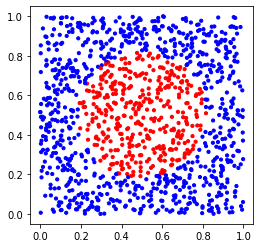

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt                             

X = torch.rand (1200,2)                         # (N,F) N - number of samples, F - number of features
Y = (torch.sum((X - 0.5)**2, axis=1) < 0.1)     # inside or outside circle
Y = Y.float().view(-1,1)                        # float and shape (N,1) for MSE or BCELoss, not (N,)!!!
 
plt.figure (figsize=(4, 4))                                 
plt.scatter(X[:,0].numpy(), X[:,1].numpy(), c=Y[:,0].numpy(),  s=10, cmap='bwr')        
plt.show()                                                  

## Layer Sequence 

To solve the classification problem, we will create a neural network with two inputs (dimension of the feature space) and one output. If the output is 0, then we consider that this is the first class, and if the output is 1, then the second.
Let's create a neural network with one hidden layer with nH neurons.


<img src="img/nnet_2-5-1.png" style="width:600px">

For such a simple architecture in PyTorch, it is convenient to use the Sequential method inside which lists the layers and activation functions that apply to their outputs:</p>


In [17]:
nX, nH, nY = 2, 5, 1
 
model = nn.Sequential(
          nn.Linear(nX, nH),    # first (input) layer
          nn.Sigmoid(),         # its activation function
          nn.Linear(nH, nY),    # second (output) layer
          nn.Sigmoid() )        # its activation 

print(model[0].weight.shape)

torch.Size([5, 2])


## Network learning

To train the network, you need to determine the loss function and the optimization method. For the loss function, we choose the Binary Cross Entropy (BCELoss).
The optimizer will be the gradient stochastic descent. It needs to pass model parameters and two hyperparameters.
The first parameter `lr` is the learning rate, and the second: `momentum` is the degree to which previous gradient values are taken into account (smoothing).

In [18]:
loss      = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.8)   

Let's define a function that shuffles the data. Then it breaks them into batches of size `batch_size`.
If the `train=True` parameter, then after calculating the loss, the model parameters are corrected.

In [4]:
def fit(model, X,Y, batch_size=128, train=True):    
    batch_size = min(batch_size, len(X))
    totLoss, totAcc, totBatches = 0, 0, 0                # losses and  accuracies
                   
    idx = torch.randperm( len(X) )                       # permuted index list
    X, Y = X[idx], Y[idx]        
    
    model.train(train)                                   # important for Dropout, BatchNorm layers    
    for i in range(0, len(Y), batch_size):             
        nb = min(batch_size,  len(Y)-i)
        
        xb, yb = X[i: i+nb], Y[i: i+nb]                  # current batch        
                      
        y = model(xb)                                    # forward propagation
        L = loss(y, yb)                                  # calculate the loss
  
        if train:                                        # we are in learning mode
            optimizer.zero_grad()                        # reset the gradients        
            L.backward()                                 # calculate gradients            
            optimizer.step()                             # adjusting parameters
                               
        totLoss    += L.detach()
        totAcc     += (y.detach().round() == yb).float().mean()
        totBatches += 1
          
    return totLoss/totBatches, totAcc/totBatches         # mean error and accuracy

before:      loss: 0.7224 accuracy: 0.3143
epoch:  1000 loss: 0.0474 accuracy: 0.9844

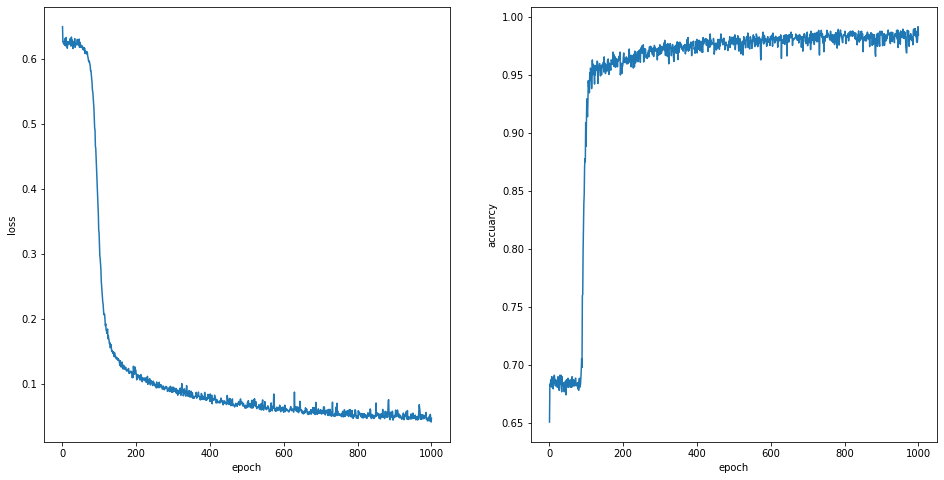

In [19]:
L, A = fit(model, X,Y, train=False)
print(f"before:      loss: {L:.4f} accuracy: {A:.4f}")

epochs = 1000                                            # number of epochs

history = [] 
for epoch in range(1,epochs+1):                          
    L,A = fit(model, X, Y)                               # one epoch
    history.append((epoch, L, A))
     
    if epoch % 100 == 0 or epoch == epochs:                 
        print(f'\repoch: {epoch:5d} loss: {L:.4f} accuracy: {A:.4f}', end="" ) 
    
history = np.array(history)                              # learning output
plt.figure(figsize=(16,8))              
plt.subplot(1, 2, 1); plt.plot(history[:,0], history[:, 1]); plt.xlabel('epoch'); plt.ylabel('loss')  
plt.subplot(1, 2, 2); plt.plot(history[:,0], history[:, 2]); plt.xlabel('epoch'); plt.ylabel('accuarcy')
plt.show()

## Classification visualization

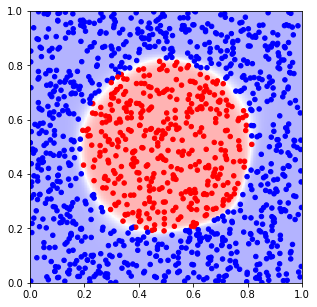

In [23]:
X_MIN, X_MAX, X_NUM = 0., 1., 100
Y_MIN, Y_MAX, Y_NUM = 0., 1., 100

x = np.linspace(X_MIN, X_MAX, X_NUM, dtype=np.float32)
y = np.linspace(Y_MIN, Y_MAX, Y_NUM, dtype=np.float32)
x, y =  np.meshgrid(x, y)    

inp = torch.cat([torch.tensor(x).view(-1,1), torch.tensor(y).view(-1,1)], 1)

z  = model(inp).detach().view(X_NUM, Y_NUM).numpy()
    
plt.figure(figsize=(5,5))
plt.imshow(z, extent=[X_MIN, X_MAX, Y_MIN, Y_MAX],  origin='lower', cmap='bwr', alpha=0.3)
plt.scatter(X.numpy()[:,0], X.numpy()[:,1], c=Y.numpy()[:,0],  s=20, cmap='bwr')        
plt.show()

## Output network structures

In [7]:
print(model)     

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


In [8]:
tot = 0
for k, v in model.state_dict().items():
    pars = np.prod(list(v.shape)); tot += pars
    print(f'{k:20s} :{pars:7d}  shape: {tuple(v.shape)} ')
print(f"{'total':20s} :{tot:7d}")

0.weight             :     10  shape: (5, 2) 
0.bias               :      5  shape: (5,) 
2.weight             :      5  shape: (1, 5) 
2.bias               :      1  shape: (1,) 
total                :     21


In the general case, the values of the model parameters are displayed in the following way:

In [26]:
for name, param in model.named_parameters():
    print(name, param.numel(), param.size(), param.data.numpy())

0.weight 10 torch.Size([5, 2]) [[ -8.371234    8.020071 ]
 [ 11.708366    5.2653646]
 [  1.5458044  -1.9303646]
 [-13.805217   14.360778 ]
 [ -5.327455  -11.798516 ]]
0.bias 5 torch.Size([5]) [ -2.3431287  -11.261088     0.08320629   5.5197268    5.784156  ]
2.weight 5 torch.Size([1, 5]) [[-30.782885  -28.67044     1.8775735  16.474583  -28.367083 ]]
2.bias 1 torch.Size([1]) [6.57649]


## Functional architecture

The network can be created in functional form. To do this, you need to define a class. The corresponding layers are created in its constructor. The forward method defines how the input is propagated to the output of the network. Such a mechanism is necessary to create networks with a complex architecture. In simple cases, it's better to use Sequential (it's a bit faster).

In [29]:
class TwoLayersNet(nn.Module):
    def __init__(self, nX, nH, nY):        
        super(TwoLayersNet, self).__init__()     # ancestor constructor with this name
         
        self.fc1 = nn.Linear(nX, nH)             # create layers
        self.fc2 = nn.Linear(nH, nY)             
          
    def forward(self, x):                        # forward pass for input x is set
        x = self.fc1(x)                          
        x = nn.Sigmoid()(x)                      
        x = self.fc2(x)                          
        x = nn.Sigmoid()(x)                      
        return x
          
model = TwoLayersNet(2, 5, 1)                    # network instance

## Saving and loading

In [30]:
import datetime
  
state = {'info':      "This is my first network",# arbitrary description
         'date':      datetime.datetime.now(),   # date and time
         'model':     str(model),                # model architecture
         'state' :    model.state_dict(),        # model parameters
         'optimizer': optimizer.state_dict()}    # optimizer state
 
torch.save(state, 'state.pt')             # save to file

In [31]:
state = torch.load('state.pt')            # upload file
print(state['model'])                            # model architecture

m = TwoLayersNet(2, 5, 1)                        # network instance with correct architecture
optimizer = torch.optim.SGD(m.parameters(),lr=1) # optimizer (any parameters)
 
m.        load_state_dict(state['state'])        # get model parameters
optimizer.load_state_dict(state['optimizer'])    # get the state of the optimizer
 
print(state['info'], state['date'])              # supporting information

TwoLayersNet(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)
This is my first network 2022-08-10 11:16:41.496682
